In [1]:
import sys
# TODO: clean this up
sys.path.insert(0, "/Users/danieldubovski/projects/deep_query_optimization/")
sys.path

['/Users/danieldubovski/projects/deep_query_optimization/',
 '/Users/danieldubovski/projects/deep_query_optimization/dqo/datasets',
 '/Users/danieldubovski/projects/deep_query_optimization',
 '/usr/local/anaconda3/envs/py37/lib/python37.zip',
 '/usr/local/anaconda3/envs/py37/lib/python3.7',
 '/usr/local/anaconda3/envs/py37/lib/python3.7/lib-dynload',
 '',
 '/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages',
 '/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/extensions',
 '/Users/danieldubovski/.ipython']

In [2]:
from dqo.datasets import QueriesDataset
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
ds = QueriesDataset("imdb:small_uniform")

In [4]:
db = ds.schema()

In [5]:
df = ds.load()

2020-08-16 18:13:18,074 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/augmented_part_00.csv [1/1]
2020-08-16 18:13:18,906 | dqo.datasets | INFO | Loaded 87119 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/augmented_part_00.csv [1/1]


In [6]:
df.runtime.describe()

count    87119.000000
mean        16.047108
std         51.970824
min          0.146313
25%          0.480953
50%          0.941739
75%          2.428122
max        902.783638
Name: runtime, dtype: float64

(array([54615., 11942.,  4595.,  3954.,     0.,  2046.,  2471.,  2417.,
         2249.,  2830.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

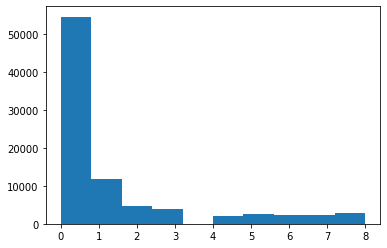

In [7]:
df['bucket'] = df.runtime.apply(np.log2).apply(lambda x: min(x, 8)).apply(lambda x: max(0, x)).apply(np.round)
plt.hist(df['bucket'])

In [8]:
df.groupby('bucket').count().min()

query      2046
runtime    2046
dtype: int64

In [10]:
df = ds.groom()

100%|██████████| 87119/87119 [13:39<00:00, 106.31it/s]


In [11]:
len(ds.df), len(df)

(87119, 87034)

In [14]:
ds.df = df

In [15]:
ds.save(prefix='clean_augmented')

In [19]:
df.groupby('nodes').count()

,query,runtime,bucket,parts
nodes,,,,
2.0,9,9,9,9
3.0,14,14,14,14
4.0,74,74,74,74
5.0,153,153,153,153
6.0,438,438,438,438
...,...,...,...,...
69.0,68,68,68,68
70.0,85,85,85,85
71.0,34,34,34,34


(array([3514., 5784., 5999., 4958., 4177., 4565., 2084.,  874.,  168.,
          25.]),
 array([ 2. , 10.7, 19.4, 28.1, 36.8, 45.5, 54.2, 62.9, 71.6, 80.3, 89. ]),
 <BarContainer object of 10 artists>)

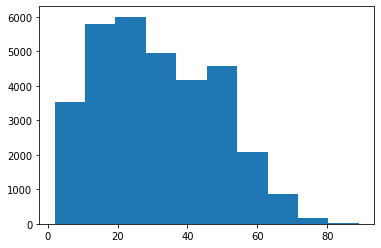

In [13]:
plt.hist(ds.df['nodes'])

___
# augment
---

In [16]:
min_bucket = ds.df[ds.df['bucket'] > 0].groupby('bucket').count().min()[0]
min_bucket

617

In [17]:
sample = ds.df[ds.df['bucket'] > 0].groupby('bucket').head(min_bucket)

(array([538., 364., 445., 504., 501., 316., 593., 441., 517., 717.]),
 array([0.50011197, 1.25010078, 2.00008958, 2.75007838, 3.50006718,
        4.25005599, 5.00004479, 5.75003359, 6.50002239, 7.2500112 ,
        8.        ]),
 <BarContainer object of 10 artists>)

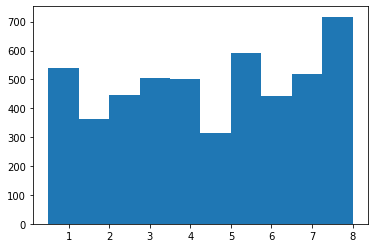

In [18]:
buckets = sample.runtime.apply(np.log2).apply(lambda x: min(x, 8)).apply(lambda x: max(0, x))
plt.hist(buckets)

In [20]:
import os

In [21]:
batch_size = 1000
for i in range(0,len(sample), batch_size):
    aug_df = ds.augment(df[i:i+batch_size])
    f_name = os.path.join(ds.input_path, f'aug_{batch_size}_{i}:{i + len(aug_df)}')
    print(i, len(aug_df), f_name)
    aug_df.to_csv(f_name, header=False, index=False)

100%|██████████| 1000/1000 [01:40<00:00,  9.95it/s]


0 17021 /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/aug_1000_0:17021


100%|██████████| 1000/1000 [02:01<00:00,  8.23it/s]


1000 20975 /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/aug_1000_1000:21975


100%|██████████| 1000/1000 [01:51<00:00,  8.14it/s]


2000 16246 /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/aug_1000_2000:18246


100%|██████████| 1000/1000 [02:12<00:00,  6.89it/s]


3000 16557 /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/aug_1000_3000:19557


100%|██████████| 1000/1000 [02:32<00:00,  6.55it/s]


4000 16320 /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/aug_1000_4000:20320


In [22]:
len(aug_df)

16320

In [1]:
ds.df.to_csv(os.path.join(ds.input_path, 'clean.csv'), header=False, index=False, columns=['query', 'runtime'])

NameError: name 'ds' is not defined

(array([2129., 1082.,  830., 1333., 1196.,  528., 1674.,  793., 1180.,
        1505.]),
 array([0.50102831, 1.25092548, 2.00082265, 2.75071982, 3.50061699,
        4.25051415, 5.00041132, 5.75030849, 6.50020566, 7.25010283,
        8.        ]),
 <BarContainer object of 10 artists>)

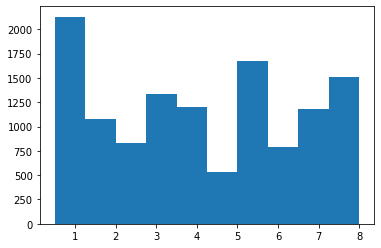

In [13]:
buckets = aug_df.runtime.apply(np.log2).apply(lambda x: min(x, 8)).apply(lambda x: max(0, x))
plt.hist(buckets)


In [16]:
ds.save()

In [25]:
df['partition'] = df.runtime.apply(np.log2).apply(lambda x: min(x, 8)).apply(lambda x: max(0, x))
slow_df = df[df['partition'] > 4]
len(slow_df)

5061

In [17]:
import os
os.getcwd()

'/Users/danieldubovski/projects/deep_query_optimization/dqo/datasets'

In [40]:
with open('/Users/danieldubovski/projects/deep_query_optimization/dqo/localhost_imdb.qcp', 'w+') as dcp_file:
    for idx, row in slow_df.iterrows():
        dcp_file.write(f"{row['query']}\n")
    

In [98]:
from dqo.relational import SQLParser
from tqdm import tqdm

In [ ]:
queries = []

for idx, row in tqdm(ds.df.iterrows(), total=ds.df.shape[0]):
    queries.append(SQLParser.to_query(row['query']))

In [120]:
db

Database(tables=[Table(aka_name, [Column(id, number), Column(person_id, number), Column(name, string), Column(imdb_index, string), Column(name_pcode_cf, string), Column(name_pcode_nf, string), Column(surname_pcode, string), Column(md5sum, string)]), Table(aka_title, [Column(id, number), Column(movie_id, number), Column(title, string), Column(imdb_index, string), Column(kind_id, number), Column(production_year, number), Column(phonetic_code, string), Column(episode_of_id, number), Column(season_nr, number), Column(episode_nr, number), Column(note, string), Column(md5sum, string)]), Table(cast_info, [Column(id, number), Column(person_id, number), Column(movie_id, number), Column(person_role_id, number), Column(note, string), Column(nr_order, number), Column(role_id, number)]), Table(char_name, [Column(id, number), Column(name, string), Column(imdb_index, string), Column(imdb_id, number), Column(name_pcode_nf, string), Column(surname_pcode, string), Column(md5sum, string)]), Table(comp_ca

In [111]:
from collections import defaultdict, Counter
tables = defaultdict(int)
for query in queries:
    c = Counter([r.name for r in query._relations])
    for k, v in c.items():
        tables[k] += v
    
tables_df = pd.DataFrame(tables.items(), columns=['table', 'count'])
tables_df
    

,table,count
0,cast_info,29
1,title,55
2,kind_type,34
3,role_type,16
4,company_name,41
5,complete_cast,26
6,char_name,29
7,aka_name,18
8,person_info,17
9,comp_cast_type,28
